# Inferential Statistics III - Bayesian

### Loading the data and performing an initial view

In [1]:
%matplotlib inline
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

import seaborn as sns
sns.set();

from scipy.stats import gamma
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

In [2]:
medical = pd.read_csv('data/insurance2.csv')

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

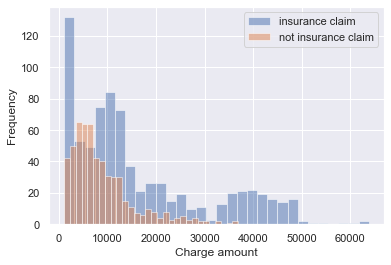

In [5]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

The distributions in the above plot suggest some possible exponential-like distribution, particularly for the non-insured charges. The insurance claim charges appear to be possibly multimodal. We start by testing the gamma distribution for describing the distribution of non-insurance charges. 

$$ C_1 \sim \text{Gamma}(\alpha, \beta)  $$

The $\alpha$ and $\beta$ parameters must be positive real numbers, so we can try to model them with an exponential distribution. We do not have strong beliefs for possible values of these exponential's parameters, so we will just use a best estimate for their values.

### Initial parameter estimation

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made as described [here](https://wiki.analytica.com/index.php?title=Gamma_distribution).

In [6]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

### Initial simulation

Let's draw the same number of random variates from this distribution and compare to our observed data.

In [7]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

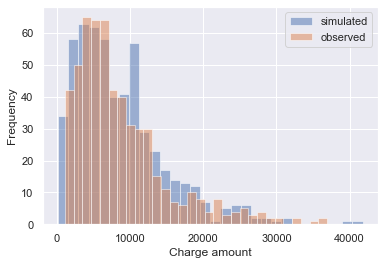

In [8]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

Well it doesn't look too bad! We're not a million miles off. But can we do better? We have a plausible form for the distribution of charge amounts and potential values for that distribution's parameters so we can already draw random variates from that distribution to perform simulations. But we don't know if we have a _best_ estimate for the population parameters, and we also only have a single estimate each for $\alpha$ and $\beta$; we aren't capturing our uncertainty in their values. Can we take a Bayesian inference approach to estimate the parameters?

### Creating a PyMC3 model

In [9]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

__A:__

In [10]:
with pm.Model() as model:
    alpha_ = pm.Exponential('alpha_',1/alpha_est)
    rate_ = pm.Exponential('rate_',1/rate_est)

In [11]:
with model:
    observation = pm.Gamma('obs',alpha=alpha_,beta=rate_,observed=no_insurance)

In [12]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate_, alpha_]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:22<00:00, 1866.00draws/s]


__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

__A:__

In [13]:
# Calculate the 95% credible intervals
alpha_hpd = pm.hpd(trace['alpha_'],credible_interval=0.95)
beta_hpd = pm.hpd(trace['rate_'],credible_interval=0.95)
print('95% credible interval for alpha: ({}, {})'.format(alpha_hpd[0],alpha_hpd[1]))
print('95% credible interval for beta: ({}, {})'.format(beta_hpd[0],beta_hpd[1]))

95% credible interval for alpha: (1.9829366989944495, 2.4763735322804328)
95% credible interval for beta: (0.00022258110575079212, 0.0002853862162156133)


C:\ProgramData\Anaconda3\envs\springboard_miniprojects\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\springboard_miniprojects\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\springboard_miniprojects\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\springboard_miniprojects\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: Use

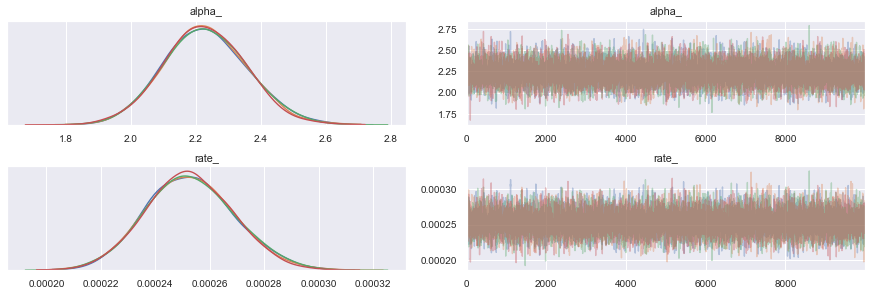

In [14]:
# Make line plots for the posterior values
pm.plots.traceplot(data=trace, var_names=('alpha_','rate_'));

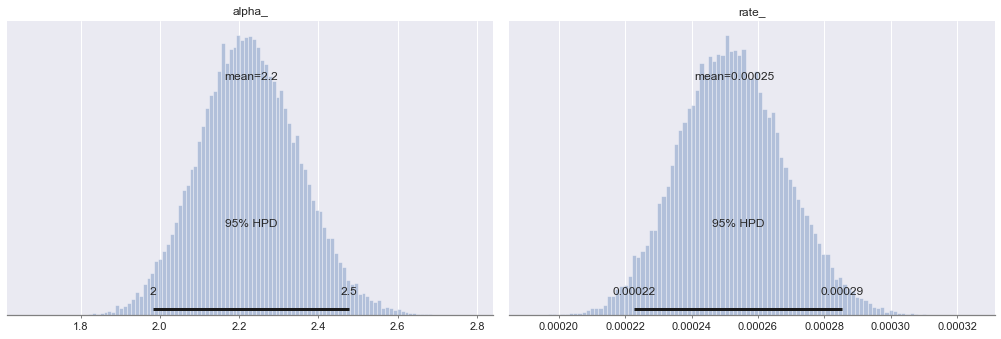

In [15]:
# Plot histograms with 95% credible intervals
pm.plots.plot_posterior(data=trace,
                        var_names=('alpha_','rate_'),
                        kind='hist',credible_interval=0.95);

These plots look okay. I assume that a bad plot would be characterized by a much wider credible interval, which would suggest a high level of uncertainty for the values of the parameters.

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

__A:__ This was performed above, and the plots look to be as expected based on the examples in the documentation. 

__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

__A:__

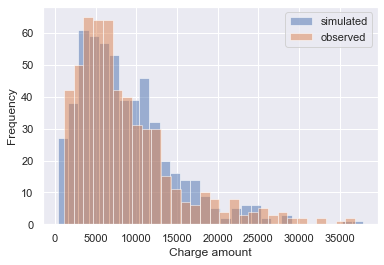

In [16]:
# Get new parameter estimates
alpha_est = np.mean(trace['alpha_'])
beta_est = 1 / np.mean(trace['rate_'])

# Simulate observations and plot histograms
seed(47)
best_shot_simulated = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)
_ = plt.hist(best_shot_simulated, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()